In [1]:
import pandas as pd
import numpy as np
import collections
import scipy.sparse as sp_sparse
import tables
from matplotlib import pyplot as plt
import seaborn as sns
import scanpy as sc
import math
from sklearn.cluster import KMeans,DBSCAN
from sklearn.preprocessing import StandardScaler

In [2]:
import tcr_emb_code
import data_processing

In [3]:
# can set the DPI on save here
sc.set_figure_params(figsize=(6, 6), frameon=False)
sc.settings.n_jobs=2

In [4]:
#!unzip ank_spond_scrnaseq.zip

In [5]:
donor = 'donor6'

In [6]:
filtered_matrix_h5_path = {'donor1':'data/ank_spond_scrnaseq/G_A1_filtered_feature_bc_matrix.h5',
                           'donor2':'data/ank_spond_scrnaseq/I1_C1_filtered_feature_bc_matrix.h5',
                           'donor3':'data/ank_spond_scrnaseq/I2_B1_filtered_feature_bc_matrix.h5',
                           'donor4':'data/ank_spond_scrnaseq/K1_E1_filtered_feature_bc_matrix.h5',
                           'donor5':'data/ank_spond_scrnaseq/K2_D1_filtered_feature_bc_matrix.h5',
                           'donor6':'data/ank_spond_scrnaseq/N1_F1_filtered_feature_bc_matrix.h5'}

clones_path = {'donor1':'data/ank_spond_scrnaseq/G_vdj.clones.tsv',
               'donor2':'data/ank_spond_scrnaseq/I1_vdj.clones.tsv',
               'donor3':'data/ank_spond_scrnaseq/I2_vdj.clones.tsv',
               'donor4':'data/ank_spond_scrnaseq/K1_vdj.clones.tsv',
               'donor5':'data/ank_spond_scrnaseq/K2_vdj.clones.tsv',
               'donor6':'data/ank_spond_scrnaseq/N_vdj.clones.tsv'}

prefix = {'donor1':'ank_spond_G_A1',
               'donor2':'ank_spond_I1_C1',
               'donor3':'ank_spond_I2_B1',
               'donor4':'ank_spond_K1_E1',
               'donor5':'ank_spond_K2_D1',
               'donor6':'ank_spond_N1_F1'}

In [7]:
filtered_matrix_h5_path_1 = "data/ank_spond_scrnaseq/G_A1_filtered_feature_bc_matrix.h5"
clones_path_1 = 'data/ank_spond_scrnaseq/G_vdj.clones.tsv'

filtered_matrix_h5_path_2 = "data/ank_spond_scrnaseq/I1_C1_filtered_feature_bc_matrix.h5"
clones_path_2 = 'data/ank_spond_scrnaseq/I1_vdj.clones.tsv'

filtered_matrix_h5_path_3 = "data/ank_spond_scrnaseq/I2_B1_filtered_feature_bc_matrix.h5"
clones_path_3 = 'data/ank_spond_scrnaseq/I2_vdj.clones.tsv'

filtered_matrix_h5_path_4 = "data/ank_spond_scrnaseq/K1_E1_filtered_feature_bc_matrix.h5"
clones_path_4 = 'data/ank_spond_scrnaseq/K1_vdj.clones.tsv'

filtered_matrix_h5_path_5 = "data/ank_spond_scrnaseq/K2_D1_filtered_feature_bc_matrix.h5"
clones_path_5 = 'data/ank_spond_scrnaseq/K2_vdj.clones.tsv'

filtered_matrix_h5_path_6 = "data/ank_spond_scrnaseq/N1_F1_filtered_feature_bc_matrix.h5"
clones_path_6 = 'data/ank_spond_scrnaseq/N_vdj.clones.tsv'

In [8]:
clones = pd.read_csv(clones_path[donor],sep = '\t')

In [9]:
clones = clones.rename(columns={'tagValueCELL':'barcode','aaSeqCDR3': 'cdr3','allVHitsWithScore':'v_gene','allJHitsWithScore':'j_gene'})


In [10]:
clones['chain'] = clones['v_gene'].str[:3]

def get_features_from_h5(filename):
    with tables.open_file(filename, 'r') as f:
        mat_group = f.get_node(f.root, 'matrix')
         
        feature_ref = {}
        feature_group = f.get_node(mat_group, 'features')
        feature_ids = getattr(feature_group, 'id').read()
        feature_names = getattr(feature_group, 'name').read()
        feature_types = getattr(feature_group, 'feature_type').read()
        feature_ref['id'] = feature_ids
        feature_ref['name'] = feature_names
        feature_ref['feature_type'] = feature_types
        tag_keys = getattr(feature_group, '_all_tag_keys').read()
        for key in tag_keys:
            key = key.decode("utf-8")
            feature_ref[key] = getattr(feature_group, key).read()
        features = pd.DataFrame(feature_ref)
        features['id'] = features['id'].str.decode('utf-8')
        features['name'] = features['name'].str.decode('utf-8')
        features['feature_type'] = features['feature_type'].str.decode('utf-8')
        features['genome'] = features['genome'].str.decode('utf-8')
        
        return features
    
def get_barcodes_from_h5(filename):
    with tables.open_file(filename, 'r') as f:
        mat_group = f.get_node(f.root, 'matrix')
        barcodes = f.get_node(mat_group, 'barcodes').read()
        barcodes = pd.DataFrame(barcodes,columns = ['barcode'])
        barcodes['barcode'] = barcodes['barcode'].str.decode('utf-8')
        return barcodes
    
def get_matrix_from_h5(filename):
    with tables.open_file(filename, 'r') as f:
        mat_group = f.get_node(f.root, 'matrix')
        data = getattr(mat_group, 'data').read()
        indices = getattr(mat_group, 'indices').read()
        indptr = getattr(mat_group, 'indptr').read()
        shape = getattr(mat_group, 'shape').read()
        matrix = sp_sparse.csc_matrix((data, indices, indptr), shape=shape)
        matrix = pd.DataFrame(matrix.toarray())
    return matrix

features = get_features_from_h5(filtered_matrix_h5_path)
barcodes_raw = get_barcodes_from_h5(filtered_matrix_h5_path)
matrix = get_matrix_from_h5(filtered_matrix_h5_path)

barcodes = barcodes_raw.copy()
barcodes['barcode'] = barcodes['barcode'].str.split('-',expand = True)[0]
data = clones.merge(barcodes, on='barcode')

matrix_t = matrix.T

matrix_t.columns = list(features['name'])
matrix_t.index = list(barcodes['barcode'])
matrix_t

# Scanpy

## Scanpy multi

In [1231]:
data_ank_1 = sc.read_10x_h5(filtered_matrix_h5_path_1)
data_ank_1.var_names_make_unique()
data_ank_2 = sc.read_10x_h5(filtered_matrix_h5_path_2)
data_ank_2.var_names_make_unique()
data_ank_3 = sc.read_10x_h5(filtered_matrix_h5_path_3)
data_ank_3.var_names_make_unique()
data_ank_4 = sc.read_10x_h5(filtered_matrix_h5_path_4)
data_ank_4.var_names_make_unique()
data_ank_5 = sc.read_10x_h5(filtered_matrix_h5_path_5)
data_ank_5.var_names_make_unique()
data_ank_6 = sc.read_10x_h5(filtered_matrix_h5_path_6)
data_ank_6.var_names_make_unique()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [1232]:
data_ank_1.obs['type']= 'ank_spond'
data_ank_1.obs['sample']= 'G_A1'

data_ank_2.obs['type']= 'ank_spond'
data_ank_2.obs['sample']= 'I1_C1'

data_ank_3.obs['type']= 'ank_spond'
data_ank_3.obs['sample']= 'I2_B1'

data_ank_4.obs['type']= 'ank_spond'
data_ank_4.obs['sample']= 'K1_E1'

data_ank_5.obs['type']= 'ank_spond'
data_ank_5.obs['sample']= 'K2_D1'

data_ank_6.obs['type']= 'ank_spond'
data_ank_6.obs['sample']= 'N1_F1'

In [1233]:

adata = data_ank_1.concatenate(data_ank_2, data_ank_3, data_ank_4, data_ank_5,data_ank_6)

# and delete individual datasets to save space
del(data_ank_1, data_ank_2, data_ank_3)
del(data_ank_4, data_ank_5, data_ank_6)

In [1234]:
adata

AnnData object with n_obs × n_vars = 79199 × 36601
    obs: 'type', 'sample', 'batch'
    var: 'gene_ids', 'feature_types', 'genome'

In [1235]:
# mitochondrial genes
adata.var['mt'] = adata.var_names.str.startswith('MT-') 
# ribosomal genes
adata.var['ribo'] = adata.var_names.str.startswith(("RPS","RPL"))
# hemoglobin genes.
adata.var['hb'] = adata.var_names.str.contains(("^HB[^(P)]"))

adata.var

gene_ids    feature_types  genome     mt   ribo     hb
MIR1302-2HG  ENSG00000243485  Gene Expression  GRCh38  False  False  False
FAM138A      ENSG00000237613  Gene Expression  GRCh38  False  False  False
OR4F5        ENSG00000186092  Gene Expression  GRCh38  False  False  False
AL627309.1   ENSG00000238009  Gene Expression  GRCh38  False  False  False
AL627309.3   ENSG00000239945  Gene Expression  GRCh38  False  False  False
...                      ...              ...     ...    ...    ...    ...
AC141272.1   ENSG00000277836  Gene Expression  GRCh38  False  False  False
AC023491.2   ENSG00000278633  Gene Expression  GRCh38  False  False  False
AC007325.1   ENSG00000276017  Gene Expression  GRCh38  False  False  False
AC007325.4   ENSG00000278817  Gene Expression  GRCh38  False  False  False
AC007325.2   ENSG00000277196  Gene Expression  GRCh38  False  False  False

[36601 rows x 6 columns]

In [1236]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt','ribo','hb'], percent_top=None, log1p=False, inplace=True)

In [1237]:
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mt2'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

... storing 'type' as categorical
... storing 'sample' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


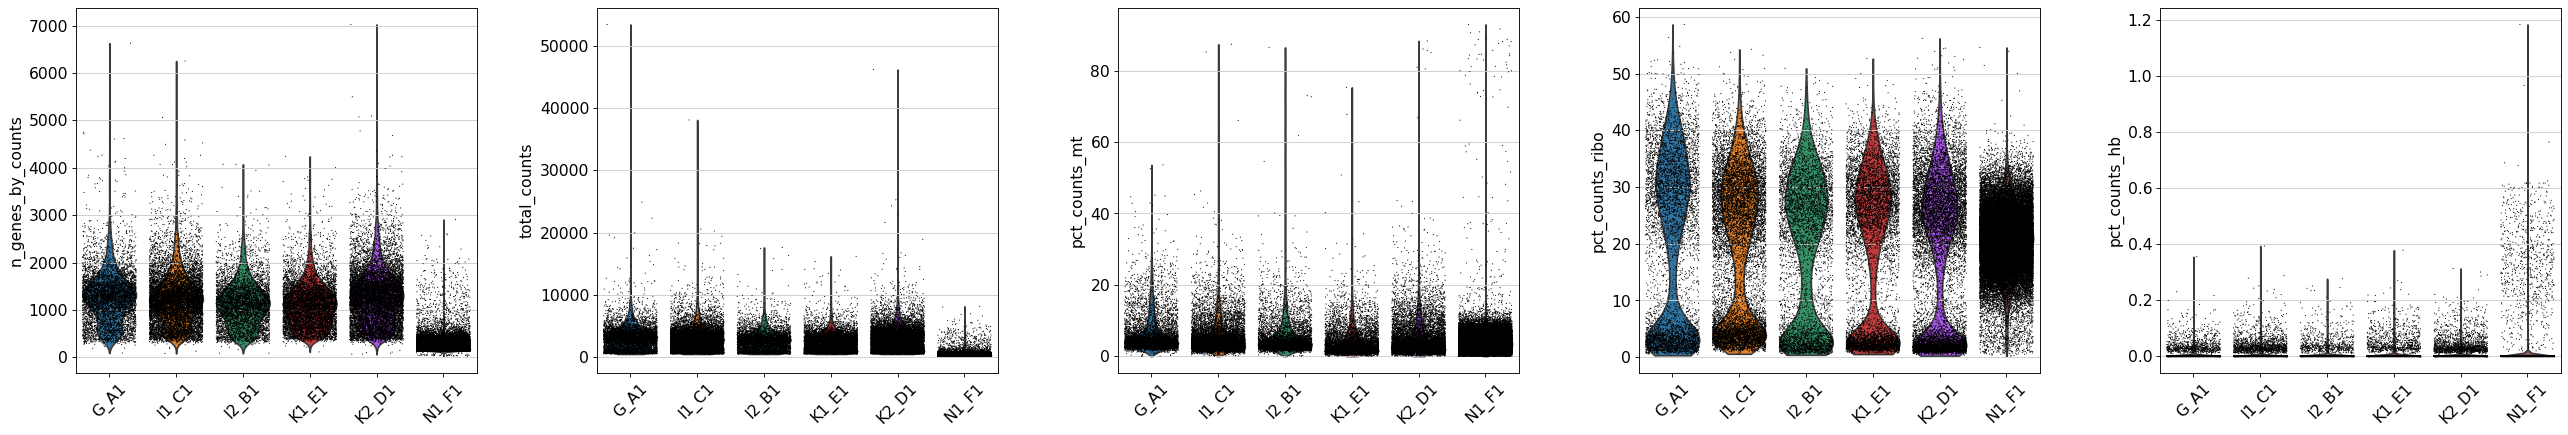

In [1238]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo', 'pct_counts_hb'],
             jitter=0.4, groupby = 'sample', rotation= 45)

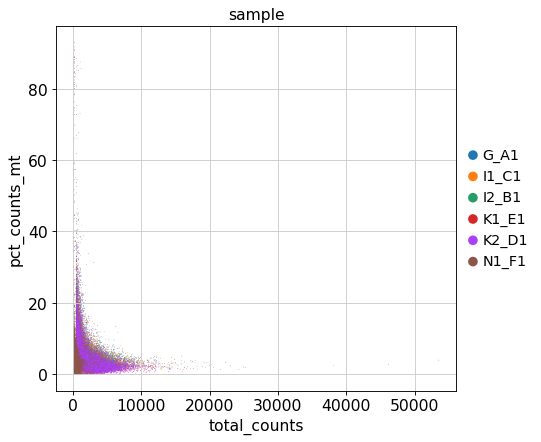

In [1239]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', color="sample")

In [1240]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

print(adata.n_obs, adata.n_vars)

61714 22688


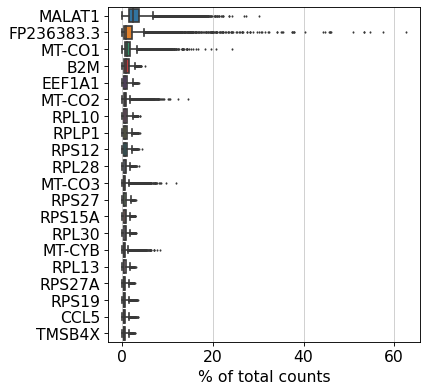

In [1241]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [1242]:
# filter for percent mito


adata = adata[adata.obs['pct_counts_mt'] < 20, :]

# filter for percent ribo > 0.05
adata = adata[adata.obs['pct_counts_ribo'] > 5, :]

print("Remaining cells %d"%adata.n_obs)

Remaining cells 49924


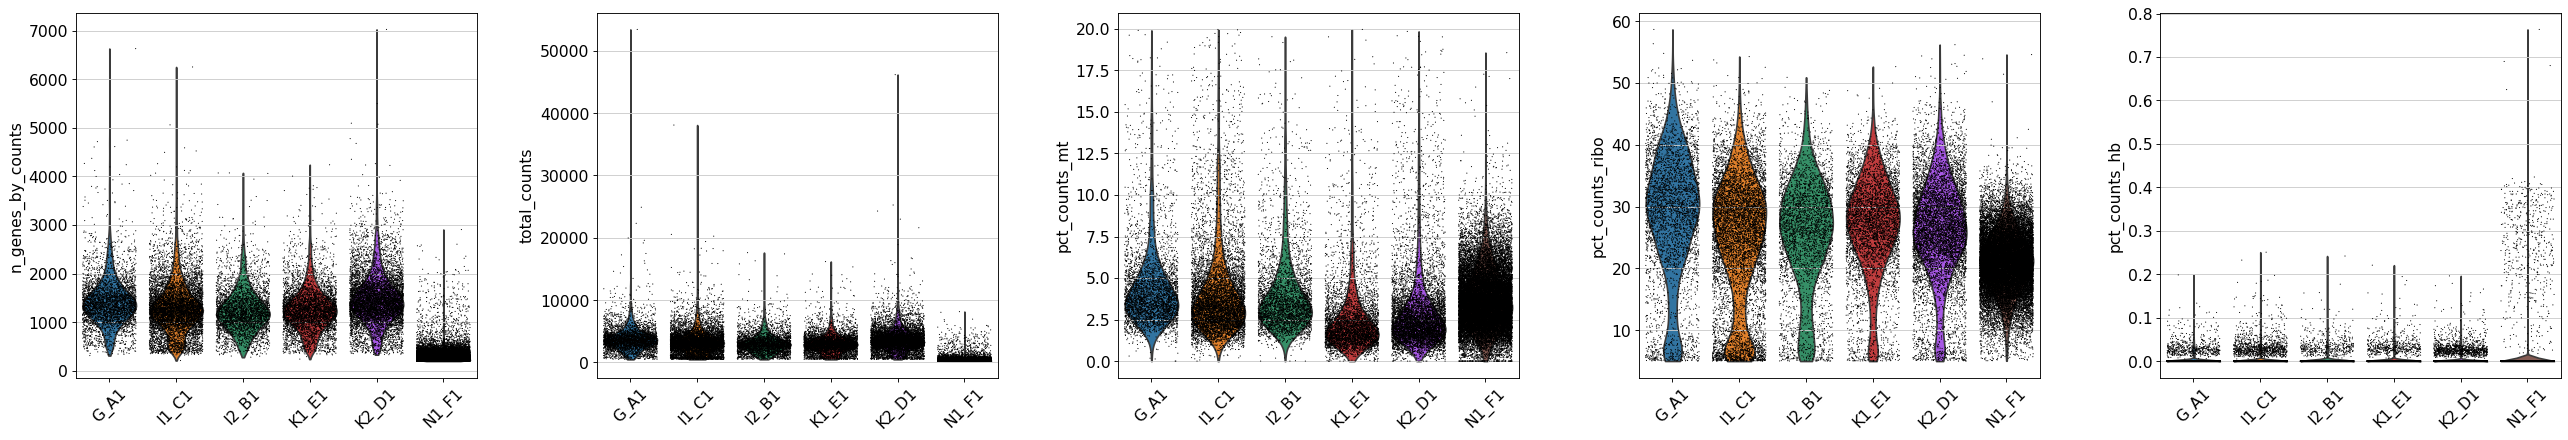

In [1243]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo', 'pct_counts_hb'],
             jitter=0.4, groupby = 'sample', rotation = 45)

In [1244]:
malat1 = adata.var_names.str.startswith('MALAT1')
# we need to redefine the mito_genes since they were first 
# calculated on the full object before removing low expressed genes.
mito_genes = adata.var_names.str.startswith('MT-')
hb_genes = adata.var_names.str.contains('^HB[^(P)]')

remove = np.add(mito_genes, malat1)
remove = np.add(remove, hb_genes)
keep = np.invert(remove)

adata = adata[:,keep]

print(adata.n_obs, adata.n_vars)

49924 22670


In [1246]:
# save normalized counts in raw slot.
adata.raw = adata

# normalize to depth 10 000
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

# logaritmize
sc.pp.log1p(adata)

# scale
sc.pp.scale(adata)

In [1247]:

sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)

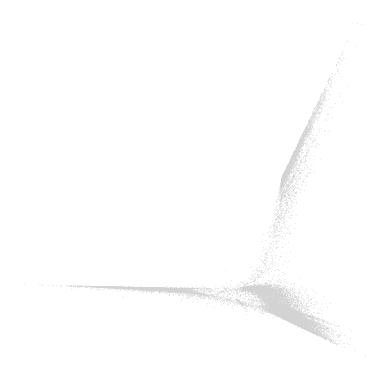

In [1248]:
sc.pl.umap(adata)

## Scanpy one

In [11]:
adata = sc.read_10x_h5(filtered_matrix_h5_path[donor])

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [12]:
adata.var_names_make_unique()

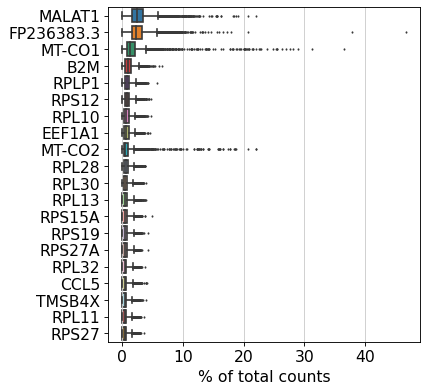

In [13]:
sc.pl.highest_expr_genes(adata, n_top=20)

### mitochondrial, ribosomal and hemoglobin genes

In [14]:
# mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes.
adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))

In [15]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=False)

... storing 'feature_types' as categorical
... storing 'genome' as categorical


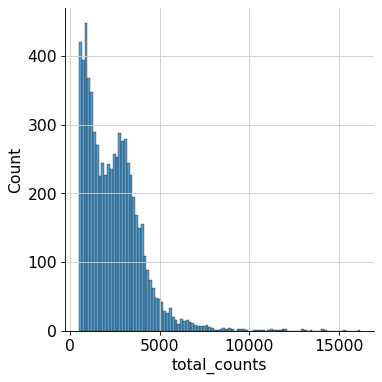

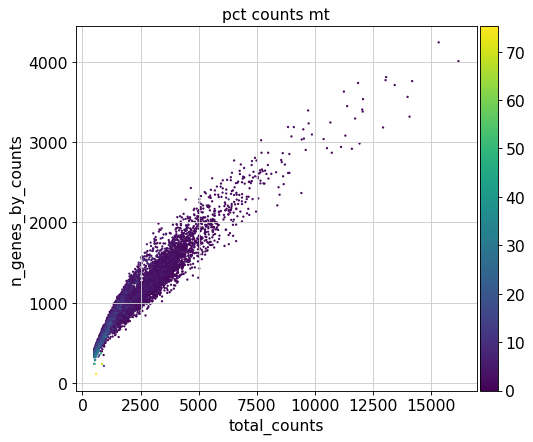

In [16]:
p1 = sns.displot(adata.obs["total_counts"], bins=100, kde=False)
# sc.pl.violin(adata, 'total_counts')
p3 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

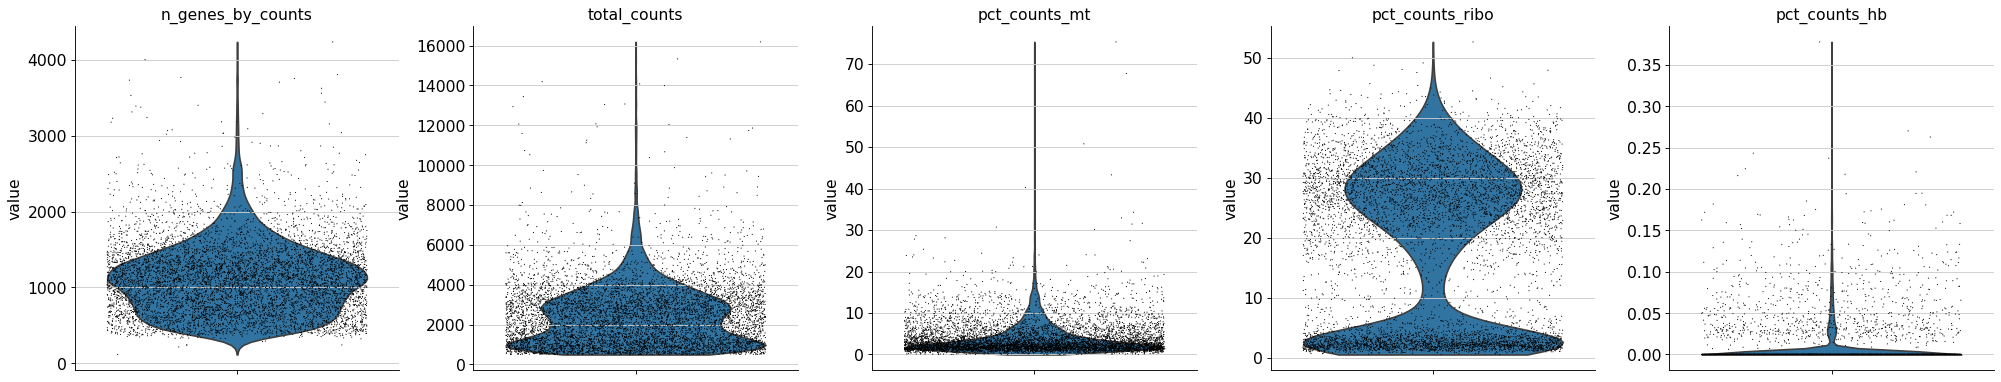

In [17]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo','pct_counts_hb'],
             jitter=0.4, multi_panel=True)

In [16]:
adata.obs["outlier"] = adata.obs.n_genes_by_counts > 3000
adata.obs["mt_outlier"] = adata.obs.pct_counts_mt > 20
adata.obs["ribo_outlier"] = adata.obs.pct_counts_ribo < 3

In [19]:
adata.obs.outlier.value_counts()

False    6935
True       29
Name: outlier, dtype: int64

In [20]:
adata.obs.mt_outlier.value_counts()

False    6919
True       45
Name: mt_outlier, dtype: int64

In [21]:
adata.obs.ribo_outlier.value_counts()

False    5273
True     1691
Name: ribo_outlier, dtype: int64

In [17]:
adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()

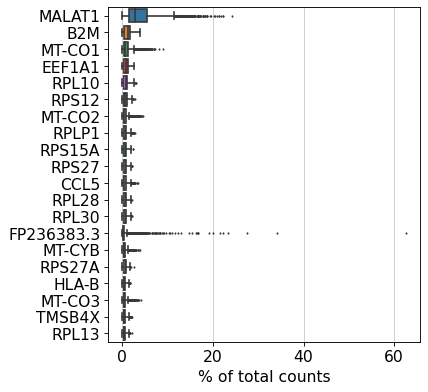

In [23]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [24]:
print(adata.n_obs, adata.n_vars)

6890 36601


In [25]:
#klrb1 = malat1 = adata.var_names.str.startswith('KLRB1')
#keep = np.invert(klrb1)

#adata = adata[:,keep]

#print(adata.n_obs, adata.n_vars)

In [18]:
malat1 = adata.var_names.str.startswith('MALAT1')
# we need to redefine the mito_genes since they were first 
# calculated on the full object before removing low expressed genes.
mito_genes = adata.var_names.str.startswith('MT-')
ribo_genes = adata.var_names.str.startswith(("RPS","RPL"))
hb_genes = adata.var_names.str.contains('^HB[^(P)]')

#ig_genes = adata.var_names.str.startswith('IG')
#trbv_genes = adata.var_names.str.startswith('TRBV') 
#trav_genes = adata.var_names.str.startswith('TRAV')
#trdv_genes = adata.var_names.str.startswith('TRDV')
#trgv_genes = adata.var_names.str.startswith('TRGV')


remove = np.add(mito_genes, malat1)
remove = np.add(remove, ribo_genes)
remove = np.add(remove, hb_genes)
#remove = np.add(remove, ig_genes)
#remove = np.add(remove, trbv_genes)
#remove = np.add(remove, trav_genes)
#remove = np.add(remove, trdv_genes)
#remove = np.add(remove, trgv_genes)

keep = np.invert(remove)

adata = adata[:,keep]

print(adata.n_obs, adata.n_vars)

40585 36472


/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


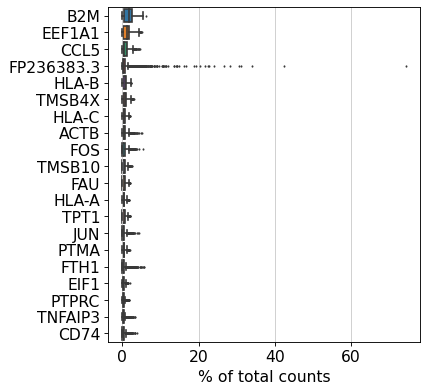

In [27]:
sc.pl.highest_expr_genes(adata, n_top=20)

### TRA/B/V/G and IG genes

In [1409]:
adata.var['trbv'] = adata.var_names.str.startswith('TRBV')  # annotate the group of mitochondrial genes as 'mt'
adata.var['trav'] = adata.var_names.str.startswith('TRAV')
adata.var['trdv'] = adata.var_names.str.startswith('TRDV')
adata.var['trgv'] = adata.var_names.str.startswith('TRGV')
adata.var['ig'] = adata.var_names.str.startswith('IG')
sc.pp.calculate_qc_metrics(adata, qc_vars=['trbv','trav','ig','trgv','trdv'], percent_top=None, log1p=False, inplace=True)

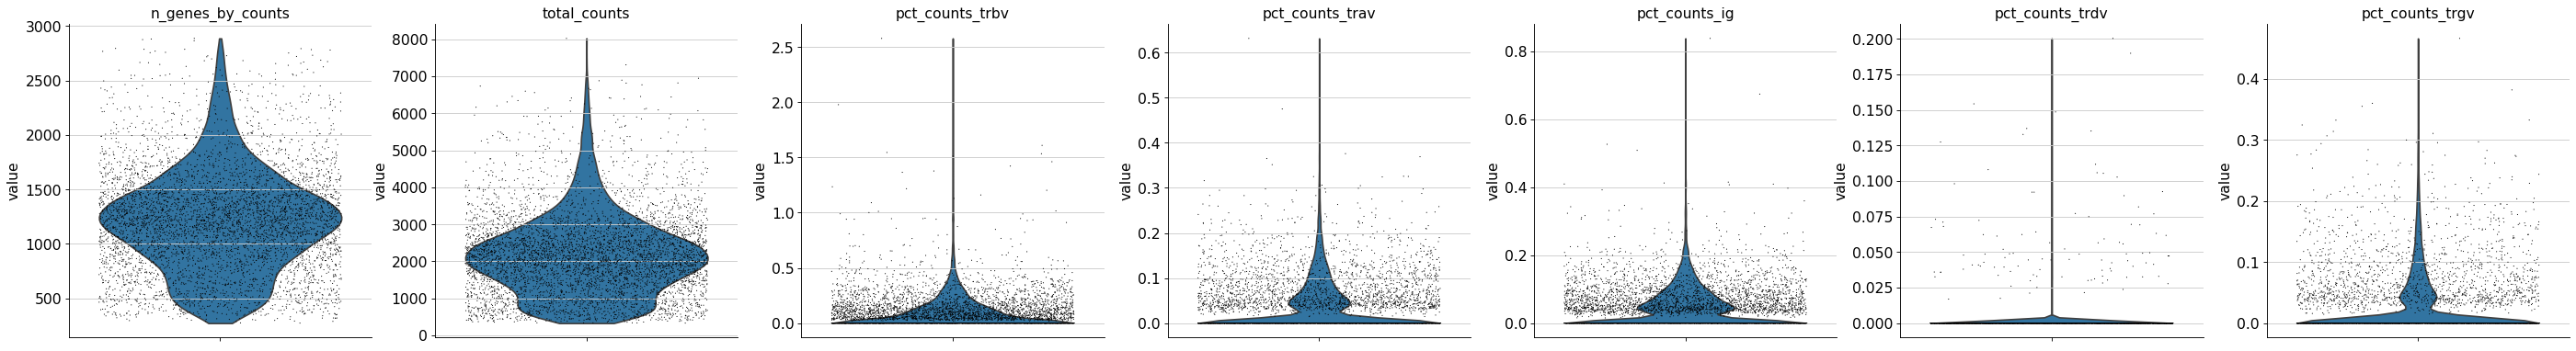

In [1410]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_trbv','pct_counts_trav','pct_counts_ig','pct_counts_trdv','pct_counts_trgv'],
             jitter=0.4, multi_panel=True)

In [1074]:
adata.obs["trbv_outlier"] = adata.obs.pct_counts_trbv > 0.6
adata.obs["trav_outlier"] = adata.obs.pct_counts_trav > 0.25
adata.obs["ig_outlier"] = adata.obs.pct_counts_ig > 0.2
adata.obs["ig_outlier"] = adata.obs.pct_counts_ig > 0.2
adata.obs["ig_outlier"] = adata.obs.pct_counts_ig > 0.2

In [1075]:
adata.obs.trbv_outlier.value_counts()

False    5107
True      112
Name: trbv_outlier, dtype: int64

In [1076]:
adata.obs.trav_outlier.value_counts()

False    5139
True       80
Name: trav_outlier, dtype: int64

In [1077]:
adata.obs.ig_outlier.value_counts()

False    5219
Name: ig_outlier, dtype: int64

In [1078]:
adata = adata[(~adata.obs.trbv_outlier) & (~adata.obs.trav_outlier) & (~adata.obs.ig_outlier)].copy()

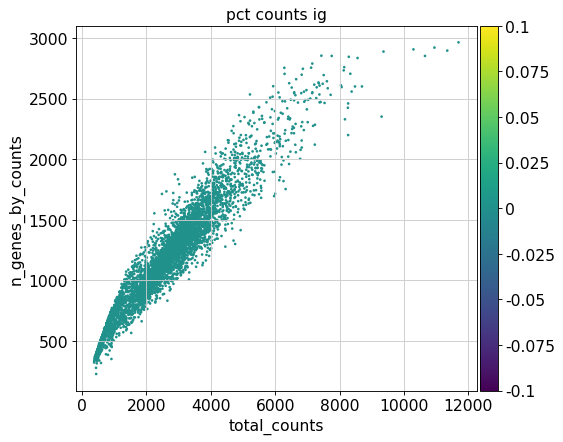

In [1115]:
p3 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_ig")

### Normaliza

In [28]:
scales_counts = sc.pp.normalize_total(adata, target_sum=None, inplace=False)
# log1p transform
adata.layers["log1p_norm"] = sc.pp.log1p(scales_counts["X"], copy=True)

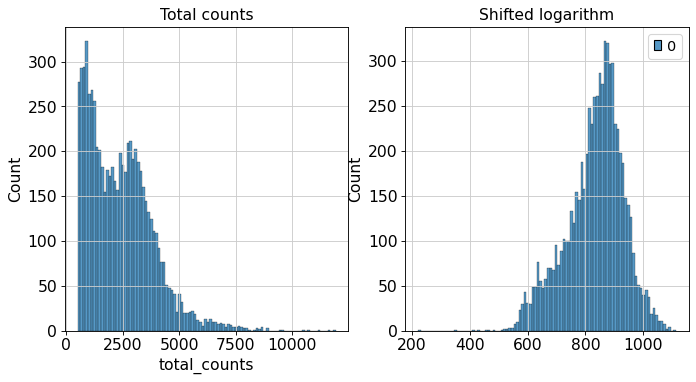

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(adata.layers["log1p_norm"].sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("Shifted logarithm")
plt.show()

In [19]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [20]:
#sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

In [21]:
#sc.pl.highly_variable_genes(adata)

In [22]:
#adata = adata[:, adata.var.highly_variable]
#sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

In [23]:
sc.pp.scale(adata)

### PCA, UMAP and TSNE

In [24]:
sc.tl.pca(adata)
#sc.pl.pca(adata, color='KLRB1')

In [25]:
sc.pp.neighbors(adata, n_neighbors=30,n_pcs=10)

/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [26]:
sc.pp.neighbors(adata)

In [27]:
sc.tl.umap(adata)

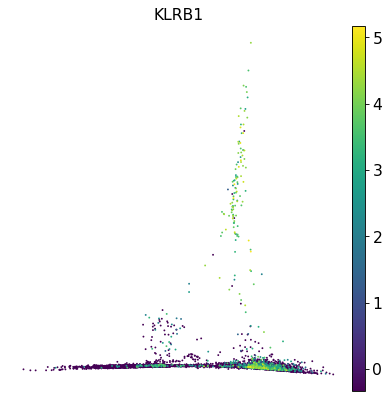

In [27]:
#sc.pl.umap(adata,color='KLRB1')

In [28]:
sc.tl.tsne(adata, use_rep="X_pca")

... storing 'feature_types' as categorical
... storing 'genome' as categorical


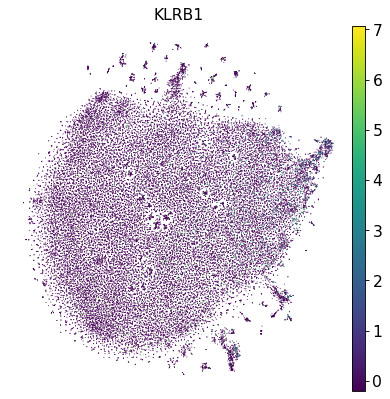

In [29]:
sc.pl.tsne(adata, color="KLRB1")

# Data proc

In [29]:
barcodes = pd.DataFrame(sc.get.obs_df(
        adata).index,columns = ['barcode'])
barcodes['barcode'] = barcodes['barcode'].str.split('-',expand = True)[0]

In [30]:
data = clones.merge(barcodes, on='barcode')

In [31]:
KLRB1_matrix = sc.get.obs_df(
        adata,
        keys=['KLRB1'])
KLRB1_matrix['barcode'] = KLRB1_matrix.index

In [32]:
data = data.merge(KLRB1_matrix,on='barcode')

In [33]:
data['KLRB1_bool']=data['KLRB1'].apply(lambda x: 1 if x>2 else 0)

In [34]:
data_b = data[data['chain']=='TRB']

In [35]:
data_b = data_b.drop_duplicates('barcode').reset_index(drop = True)

In [33]:
data_b

cloneId           barcode      tagQualityCELL  readCount  \
0          87  ATTGGACGTCTCACCT  no_quality_for_tag    22693.0   
1          10  AACTGGTTCTCCAGGG  no_quality_for_tag    21194.0   
2           9  GACTACATCCTGTACC  no_quality_for_tag    19683.0   
3          10  CATCAGAGTAAGAGGA  no_quality_for_tag    19180.0   
4          13  CGCGGTACAGGGATTG  no_quality_for_tag    18849.0   
...       ...               ...                 ...        ...   
4908     1197  TCAGATGTCTTGCAAG  no_quality_for_tag        2.0   
4909     1215  ACGCCGAAGTAGATGT  no_quality_for_tag        2.0   
4910       47  GAGTCCGCATAGACTC  no_quality_for_tag        1.0   
4911     1022  GACACGCCACCGATAT  no_quality_for_tag        1.0   
4912     1224  ACGAGCCTCCTCCTAG  no_quality_for_tag        1.0   

      uniqueMoleculeCount                                    targetSequences  \
0                      62  TGACACTGATCTGGTAAAGCCCTCATCCTGTCCTGACCCTGCCATG...   
1                      56  TGGTAAAGCTCCCATCCTGCCCTGACCCTGCCATGGGCACCAGGCT...   
2                      43  GAGGCCCCATCTCAGACCCGAGGCTAGCATGGGCTGCAGGCTGCTC...   
3                      59  TGGTAAAGCTCCCATCCTGCCCTGACCCTGCCATGGGCACCAGGCT...   
4                      43  ATCCTTCCCTGACCCTGCCATGGGCACCAGGCTCCTCTGCTGGGCG...   
...                   ...                                                ...   
4908                    2  CAGGTCCTGTTGTCAGGACTGAGCATGAGACTGCAGTGTGCCCAGT...   
4909                    1  AGATGAATGTGAGCACCTTGGAGCTGGGGGACTCGGCCCTTTATCT...   
4910                    1  ATATGGNTCCTGCTCACAGTGATCCTGATCTGGTAAAGCTCCCATC...   
4911                    1  GATACCTCATCACAGTGACTGGAAAGAAGTTAACAGTGACTTGTTC...   
4912                    1  TATATGGGACAGCAGGAGGACTCGGCCGTGTATCTCTGTGCCAGCA...   

                                        targetQualities              v_gene  \
0     +/**...44[4[44546;444444[[[[[[[[[[[[[[[[[[[[[[...   TRBV7-6*00(600.5)   
1     .**-+-+,*++++45222:88997;8967867978;6966796688...   TRBV7-2*00(209.9)   
2     ++++++++-----3645465355::555665:6545:55:565644...   TRBV4-2*00(118.7)   
3     .**-+-+,*++++45222:88997;8967867978;6966796688...   TRBV7-2*00(209.9)   
4     -++,/,,+,,-,+/,+,+,-.+,++-+..+,+,.+/../+0++,,,...  TRBV11-2*00(634.5)   
...                                                 ...                 ...   
4908  <6E6///EE</E<EEE/<A//</E/<<A//EEEE/EE/EE/<A/</...     TRBV6-5*00(490)   
4909  <A<E<A<EE<</EEAAAE/AEEA</EEEEEEEAEEEEEE[[[[[[[...     TRBV5-1*00(395)   
4910  A<<EE[![[[[[[[[[[S[[[[[[[[[)[[[[[[[[[[[[[[[[[[...   TRBV7-2*00(444.8)   
4911  EEEEEAEEEEEAEEEEEEEEEEEEEEEEEEEEEEEEAEEEEEEEEE...      TRBV27*00(760)   
4912  /AAAEAAAEEEEEAEEEEEAEEEEEEEEEEEEEEEE<<<<<<<<<<...     TRBV7-2*00(297)   

              allDHitsWithScore             j_gene  ...           aaSeqCDR1  \
0     TRBD1*00(25),TRBD2*00(25)  TRBJ2-7*00(384.7)  ...               SGHVS   
1                           NaN  TRBJ2-2*00(411.9)  ...               SGHTA   
2                           NaN  TRBJ2-1*00(434.4)  ...               LGHNA   
3                           NaN  TRBJ2-2*00(411.9)  ...               SGHTA   
4                           NaN  TRBJ1-1*00(369.2)  ...               SGHAT   
...                         ...                ...  ...                 ...   
4908  TRBD1*00(25),TRBD2*00(25)    TRBJ1-2*00(460)  ...               MYDEF   
4909  TRBD1*00(40),TRBD2*00(40)    TRBJ2-3*00(430)  ...  region_not_covered   
4910                        NaN    TRBJ2-1*00(422)  ...               SGHTA   
4911                        NaN    TRBJ2-2*00(300)  ...               MNHEY   
4912                        NaN    TRBJ1-2*00(440)  ...  region_not_covered   

                aaSeqFR2           aaSeqCDR2  \
0      LYWYRQALGQGPEFLTY              FNYEAQ   
1      LYWYRQSLGQGLEFLIY              FQGNSA   
2      MYWYKQSAKKPLELMFV              YNFKEQ   
3      LYWYRQSLGQGLEFLIY              FQGNSA   
4      LYWYQQILGQGPKLLIQ              FQNNGV   
...                  ...                 ...   
4908  region_not_c

## Embedding

In [36]:
prototypes_path = 'data/prototypes_olga.txt'
chain = 'TRB'
file_path_prefix = prefix[donor]

file_date = '100823'

In [37]:
data_b = tcr_emb_code.filter_table(data_b,chain)

In [38]:
#data_b = tcr_emb_code.filter_table(data_b,chain)
data_b = tcr_emb_code.data_filter_for_prototypes(data_b,prototypes_path)

In [39]:
data_b

cloneId           barcode      tagQualityCELL  readCount  \
0           5  CACAGTAGTATATCCG  no_quality_for_tag     7189.0   
1           8  TCAGGATCAAGGTTTC  no_quality_for_tag     8824.0   
2          54  TTCTCCTAGTGACTCT  no_quality_for_tag     8823.0   
3          37  TGACGGCTCGTTACAG  no_quality_for_tag     3370.0   
4          60  ATCCACCTCTGCGACG  no_quality_for_tag     8018.0   
...       ...               ...                 ...        ...   
2777      606  GGATTACCAAGCGTAG  no_quality_for_tag        1.0   
2778      766  GCAGTTAGTCTACCTC  no_quality_for_tag        1.0   
2779      991  ATGTGTGTCGCGTAGC  no_quality_for_tag        1.0   
2780     1138  CGATTGATCATCTGTT  no_quality_for_tag        1.0   
2781     1149  GCCAAATTCCAAGCCG  no_quality_for_tag        1.0   

      uniqueMoleculeCount                                    targetSequences  \
0                      64  AGACACAGTGCTGCCTGCCCCTTTGTGCCATGGGCTCCAGGCTGCT...   
1                      68  AAGCCCCCATCCTGGCCTGACCCTGCCATGGGCACCAGGCTCCTCT...   
2                      44         TGCGCCAGCAGCGGATACGAGGGGGTTGGAGGCTACACCTTC   
3                       9  ACAAGGGCCTCATCTAGGTGAAGGCTCCACCTGCCCCACCCTGCCA...   
4                      67  TTTAAATGAACCGGCNACCACC,AAGCCCCCATCCTGGCCTGACCC...   
...                   ...                                                ...   
2777                    1  TTCCGGGTCCTGAAGACAGGACAGAGCATGACACTGCTGTGTGCCC...   
2778                    1  GGCTCCAAGGCCACATACGAGCAAGGCGTCGAGAAGGACAAGTTTC...   
2779                    1  CAGACCTCTCTGTACTTCTGTGCCAGCAGTTCCGGGCTGGAAAACA...   
2780                    1  TCAAAGACAGAGGATTTCCTCCTCACTCTGGAGTCCGCTACCAGCT...   
2781                    1  TCTCTATAAATGAAAGTGTGCCAAGTCGCTTCTCACCTGAATGCCC...   

                                        targetQualities    v_gene  \
0     ///2/..000.//3.11/4/0050/.40/>/2/50F0..0G//1/4...   TRBV5-1   
1     +*,++++*14352128351011331110310311/11240001110...   TRBV7-8   
2            NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN   TRBV5-1   
3     --./--..2.,/4-.,.,1-.,-.+,,-+--/++.,/.++++1--0...  TRBV12-5   
4     //O<[R[/[!Y[[)*![,-++[,0),*****>A??AA[[[[[[G[[...   TRBV7-8   
...                                                 ...       ...   
2777  [[[[[SSS[[S7[[ZZZSZJ[OS[[[S[S[S[[[[S[OSS[S[[[[...   TRBV6-3   
2778  <EEEAAA<<J[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[...  TRBV20-1   
2779  /EEEEEEEAEAAW[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[...    TRBV27   
2780  AAAAAEAEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEAEEEEEE...  TRBV10-3   
2781  <<EA<<AAEEEEAA/E//EE<<6A</EEEEEEEEEEEEEEEEEEEE...   TRBV4-1   

              allDHitsWithScore   j_gene  ...           aaSeqCDR1  \
0                  TRBD1*00(30)  TRBJ1-1  ...               SGHRS   
1                  TRBD1*00(45)  TRBJ2-1  ...               SGHVS   
2                  TRBD1*00(30)  TRBJ1-2  ...  region_not_covered   
3                  TRBD2*00(30)  TRBJ2-1  ...               LGHNT   
4                  TRBD1*00(40)  TRBJ2-4  ...               SGHVS   
...                         ...      ...  ...                 ...   
2777               TRBD1*00(30)  TRBJ2-1  ...               MNHEY   
2778                        NaN  TRBJ2-3  ...  region_not_covered   
2779  TRBD1*00(25),TRBD2*00(25)  TRBJ2-4  ...  region_not_covered   
2780               TRBD1*00(30)  TRBJ2-1  ...  region_not_covered   
2781               TRBD1*00(30)  TRBJ1-2  ...  region_not_covered   

                aaSeqFR2           aaSeqCDR2  \
0      VSWYQQTPGQGLQFLFE              YFSETQ   
1      LFWYQQALGQGPEFLTY              FQNEAQ   
2     region_not_covered  region_not_covered   
3      VFWYRQTMMQGLELLAY              FRNRAP   
4      LFWYQQALGQGPEFLTY              FQNEAQ   
...                  ...                 ...   
2777   MYWYRQDPGMGLRLIHY              SVGEGT   
2778  region_not_covered  region_not_covered   
2779  region_not_covered  region_not_covered   
2780  region_not_covered  region_not_covered   
2781  region_not_covered  region_not_covered   

                 

In [40]:
tcr_emb_code.mir_clac(data_b, file_path_prefix, file_date, chain, prototypes_path)

In [41]:
data_dists_raw_path = 'data_scripts/' + file_path_prefix + file_date + '.dist.txt'
data_dists_raw = pd.read_csv(data_dists_raw_path, sep = '\t')

In [42]:
data_c_b_dist = tcr_emb_code.mir_dists_format(data_dists_raw, data_b,'barcode',True)
data_c_b_dist

cdr3_1  cdr3_10  cdr3_100  cdr3_1000  cdr3_1001  cdr3_1002  \
barcode                                                                        
CACAGTAGTATATCCG    24.0     28.0      15.0       10.0       11.0       15.0   
TCAGGATCAAGGTTTC    26.0     25.0      23.0       22.0       11.0       10.0   
TTCTCCTAGTGACTCT     8.0      9.0      21.0       15.0        3.0        4.0   
TGACGGCTCGTTACAG    29.0     16.0      19.0       32.0       15.0       14.0   
ATCCACCTCTGCGACG    15.0     33.0      19.0       18.0       15.0        4.0   
...                  ...      ...       ...        ...        ...        ...   
GGATTACCAAGCGTAG    27.0     27.0      23.0       26.0       17.0       18.0   
GCAGTTAGTCTACCTC     5.0     21.0      15.0       16.0       27.0       13.0   
ATGTGTGTCGCGTAGC    16.0     22.0      23.0       23.0       12.0        3.0   
CGATTGATCATCTGTT    33.0     16.0      15.0       22.0       14.0       33.0   
GCCAAATTCCAAGCCG    14.0     15.0      15.0       14.0        4.0        5.0   

                  cdr3_1003  cdr3_1004  cdr3_1005  cdr3_1006  ...  j_990  \
barcode                                                       ...          
CACAGTAGTATATCCG       18.0       14.0       20.0       17.0  ...   51.0   
TCAGGATCAAGGTTTC       15.0       42.0       35.0       31.0  ...   85.0   
TTCTCCTAGTGACTCT        7.0       12.0       30.0        7.0  ...   41.0   
TGACGGCTCGTTACAG       13.0       30.0       40.0       21.0  ...   85.0   
ATCCACCTCTGCGACG       27.0       32.0       25.0       27.0  ...   51.0   
...                     ...        ...        ...        ...  ...    ...   
GGATTACCAAGCGTAG       21.0       30.0       38.0       32.0  ...   85.0   
GCAGTTAGTCTACCTC       24.0       11.0        8.0       27.0  ...   62.0   
ATGTGTGTCGCGTAGC       33.0       31.0       31.0       30.0  ...   51.0   
CGATTGATCATCTGTT       10.0       26.0       33.0       25.0  ...   85.0   
GCCAAATTCCAAGCCG       19.0       12.0       13.0        5.0  ...   41.0   

                  j_991  j_992  j_993  j_994  j_995  j_996  j_997  j_998  \
barcode                                                                    
CACAGTAGTATATCCG   51.0   44.0   47.0   51.0   47.0   44.0   38.0   38.0   
TCAGGATCAAGGTTTC   49.0   62.0   62.0   85.0   62.0   62.0   54.0   54.0   
TTCTCCTAGTGACTCT   38.0   41.0   43.0   41.0   43.0   41.0   35.0   35.0   
TGACGGCTCGTTACAG   49.0   62.0   62.0   85.0   62.0   62.0   54.0   54.0   
ATCCACCTCTGCGACG   39.0   52.0   48.0   51.0   48.0   52.0   49.0   49.0   
...                 ...    ...    ...    ...    ...    ...    ...    ...   
GGATTACCAAGCGTAG   49.0   62.0   62.0   85.0   62.0   62.0   54.0   54.0   
GCAGTTAGTCTACCTC   45.0   84.0   60.0   62.0   60.0   84.0   65.0   65.0   
ATGTGTGTCGCGTAGC   39.0   52.0   48.0   51.0   48.0   52.0   49.0   49.0   
CGATTGATCATCTGTT   49.0   62.0   62.0   85.0   62.0   62.0   54.0   54.0   
GCCAAATTCCAAGCCG   38.0   41.0   43.0   41.0   43.0   41.0   35.0   35.0   

                  j_999  
barcode                  
CACAGTAGTATATCCG   51.0  
TCAGGATCAAGGTTTC   85.0  
TTCTCCTAGTGACTCT   41.0  
TGACGGCTCGTTACAG   85.0  
ATCCACCTCTGCGACG   51.0  
...                 ...  
GGATTACCAAGCGTAG   85.0  
GCAGTTAGTCTACCTC   62.0  
ATGTGTGTCGCGTAGC   51.0  
CGATTGATCATCTGTT   85.0  
GCCAAATTCCAAGCCG   41.0  

[2782 rows x 9000 columns]

# Analysis

## PCA

In [43]:

if len(data_c_b_dist)<3000:
    pc_n = len(data_c_b_dist)
else:
    pc_n = 3000
pca_df, pca_model = data_processing.pca(data_c_b_dist,n = pc_n)
pca_df_data =pca_df.copy()
pca_df_data['barcode']=data_c_b_dist.index
pca_df_data=pca_df_data.merge(data_b[['barcode','v_gene','j_gene','KLRB1','KLRB1_bool']], on='barcode')
#pca_df_data= pca_df_data.groupby(['barcode']).first().reset_index()
#pca_df_data


/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or mis

Text(0, 0.5, '1 component')

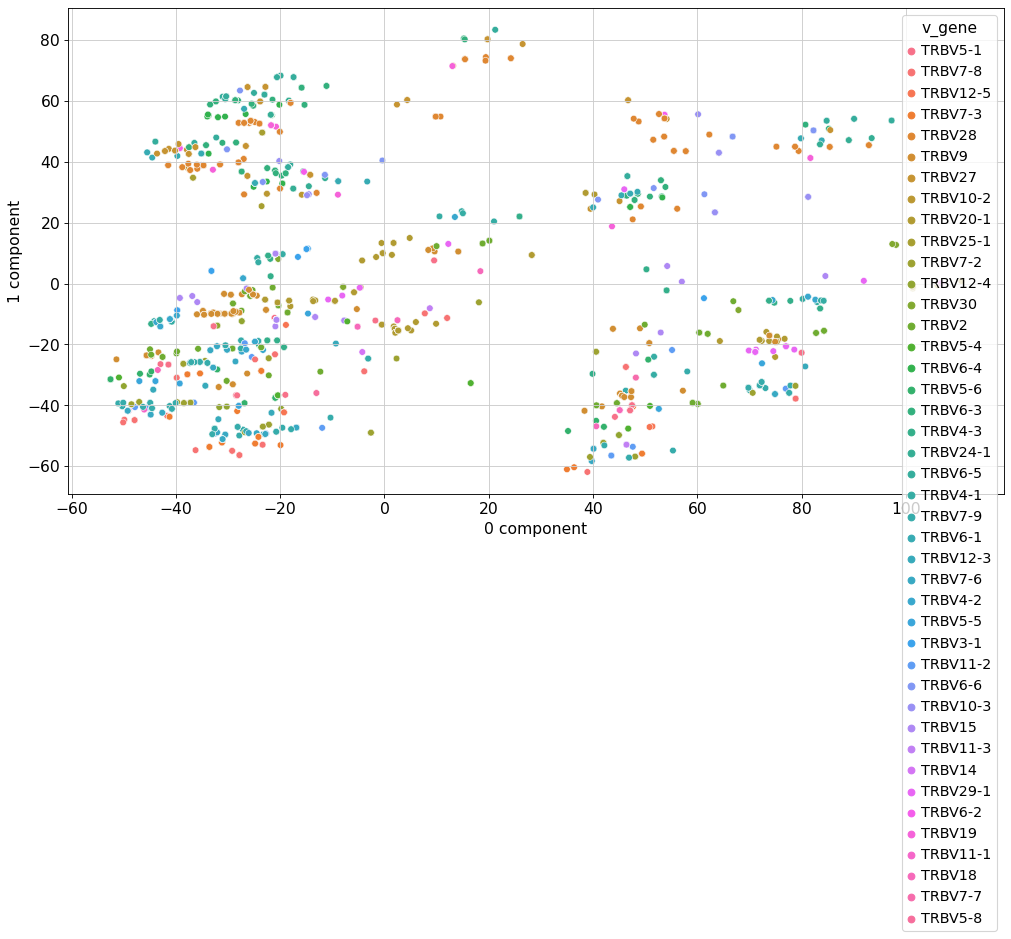

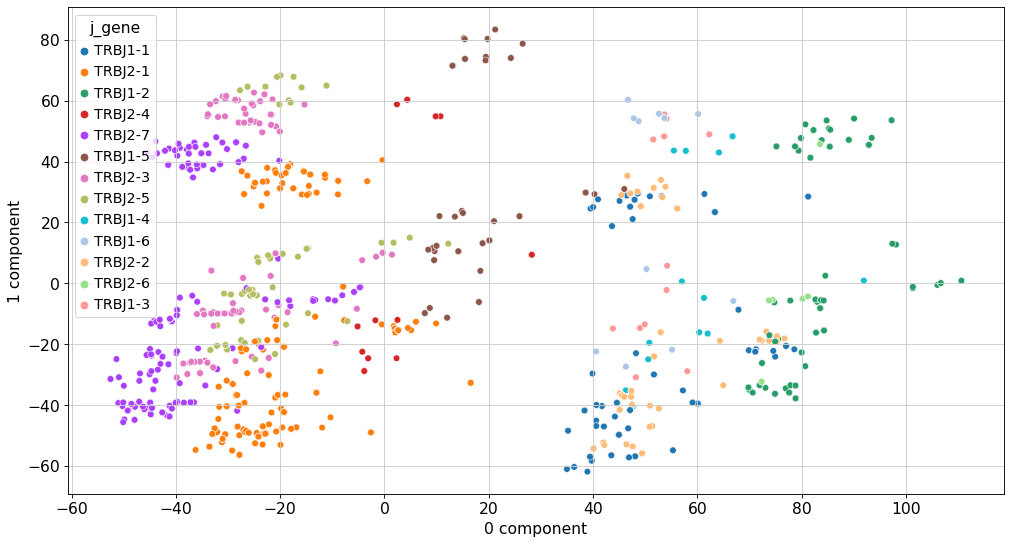

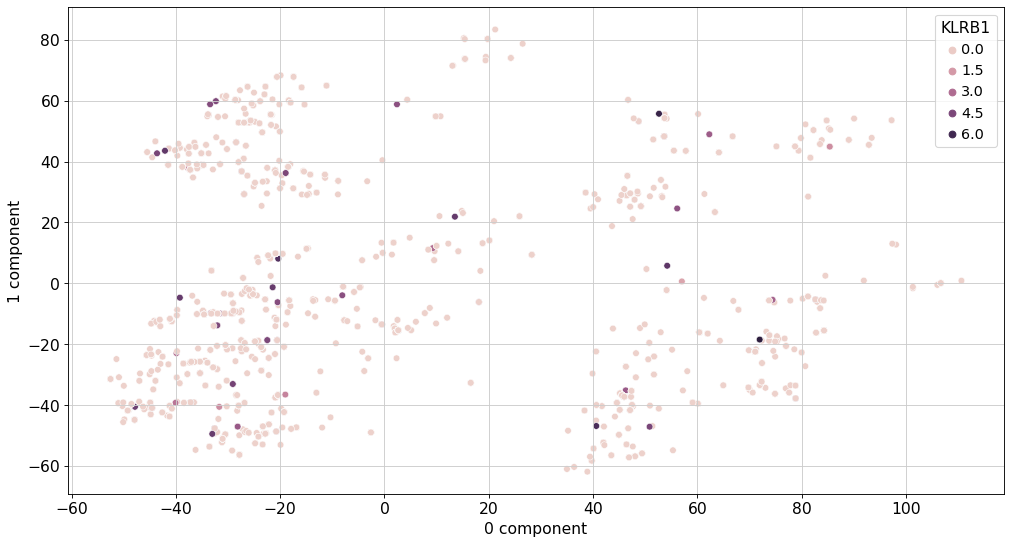

In [44]:
pc1 = 0
pc2 = 1
plt.figure(figsize=(15,8))
ax = sns.scatterplot(pc1, pc2, data=pca_df_data,hue='v_gene')
#ax.set_title("PCA 10x data, colored by antigene epitope")
ax.set_xlabel(str(pc1)+" component")
ax.set_ylabel(str(pc2)+" component")
plt.figure(figsize=(15,8))
ax = sns.scatterplot(pc1, pc2, data=pca_df_data,hue='j_gene')
#ax.set_title("PCA 10x data, colored by antigene epitope")
ax.set_xlabel(str(pc1)+" component")
ax.set_ylabel(str(pc2)+" component")
plt.figure(figsize=(15,8))
ax = sns.scatterplot(pc1, pc2, data=pca_df_data,hue='KLRB1')
#ax.set_title("PCA 10x data, colored by antigene epitope")
ax.set_xlabel(str(pc1)+" component")
ax.set_ylabel(str(pc2)+" component")

## Anova

In [54]:
from sklearn.feature_selection import f_classif
def pc_anova(data,pc_n, group):
    pc_anova = pd.DataFrame(columns=['pc','F','pvalue'])

    for n in range(0,pc_n):
        F,pval = f_classif(np.array(data[n]).reshape(-1,1),data[group])
        pc_anova = pc_anova.append({'pc': n ,'F': float(F),'pvalue':float(pval)},ignore_index=True)
    
    return pc_anova

In [109]:
pc_anova_df = pc_anova(pca_df_data,pc_n, 'KLRB1_bool')
pc_anova_df = pc_anova_df.sort_values('pvalue').reset_index(drop=True)
pc_selected = list(pc_anova_df['pc'].head(100))

## Umap

In [109]:
##import umap

/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [203]:
##scaled_pca_df = StandardScaler().fit_transform(pca_df[pc_selected])

In [204]:
#reducer = umap.UMAP()
#umap_df = reducer.fit_transform(scaled_pca_df)
#umap_df.shape

(5091, 2)

In [205]:
#umap_df_data = pd.DataFrame(umap_df)
#umap_df_data['barcode'] = data_c_b_dist.index
#umap_df_data=umap_df_data.merge(data_b[['barcode','j_gene','v_gene','KLRB1']], on='barcode')

In [ ]:
#plt.figure(figsize=(15,8))
#ax = sns.scatterplot(0, 1, data=umap_df_data, hue='KLRB1')
#ax.set_title("UMAP of ank spond data after PCA, colored by KLRB1")
#plt.figure(figsize=(15,8))
#ax = sns.scatterplot(0, 1, data=umap_df_data, hue='j_gene')
#ax.set_title("UMAP of ank spond data after PCA, colored by j_gene")

## TSNE

In [45]:
X_embedded = data_processing.tsne(pca_df,2,10,20)
tsne_df = pd.DataFrame(data = X_embedded, columns = ['DM1', 'DM2'])


tsne_df_data = tsne_df.copy()
tsne_df_data['barcode'] = data_c_b_dist.index
tsne_df_data=tsne_df_data.merge(data_b[['barcode','j_gene','v_gene','KLRB1','KLRB1_bool']], on='barcode')
#tsne_df_data= tsne_df_data.groupby(['cdr3']).first().reset_index()

tsne_df_data

DM1         DM2           barcode   j_gene    v_gene     KLRB1  \
0      43.060963  -96.208519  CACAGTAGTATATCCG  TRBJ1-1   TRBV5-1 -0.205393   
1     -46.038109 -100.084473  TCAGGATCAAGGTTTC  TRBJ2-1   TRBV7-8 -0.205393   
2     110.594223  -24.563480  TTCTCCTAGTGACTCT  TRBJ1-2   TRBV5-1 -0.205393   
3      10.777803  -93.623436  TGACGGCTCGTTACAG  TRBJ2-1  TRBV12-5 -0.205393   
4      -5.587585  -37.239628  ATCCACCTCTGCGACG  TRBJ2-4   TRBV7-8 -0.205393   
...          ...         ...               ...      ...       ...       ...   
2777   -9.102558   41.075836  GGATTACCAAGCGTAG  TRBJ2-1   TRBV6-3 -0.205393   
2778   13.459515   18.644468  GCAGTTAGTCTACCTC  TRBJ2-3  TRBV20-1 -0.205393   
2779   25.514006   55.346947  ATGTGTGTCGCGTAGC  TRBJ2-4    TRBV27 -0.205393   
2780  -28.515627   41.120495  CGATTGATCATCTGTT  TRBJ2-1  TRBV10-3 -0.205393   
2781  114.757027   -6.423650  GCCAAATTCCAAGCCG  TRBJ1-2   TRBV4-1 -0.205393   

      KLRB1_bool  
0              0  
1              0  
2              0  
3              0  
4              0  
...          ...  
2777           0  
2778           0  
2779           0  
2780           0  
2781           0  

[2782 rows x 7 columns]

/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'TSNE of ank spond data after PCA, colored by KLRB1, ank_spond_N1_F1')

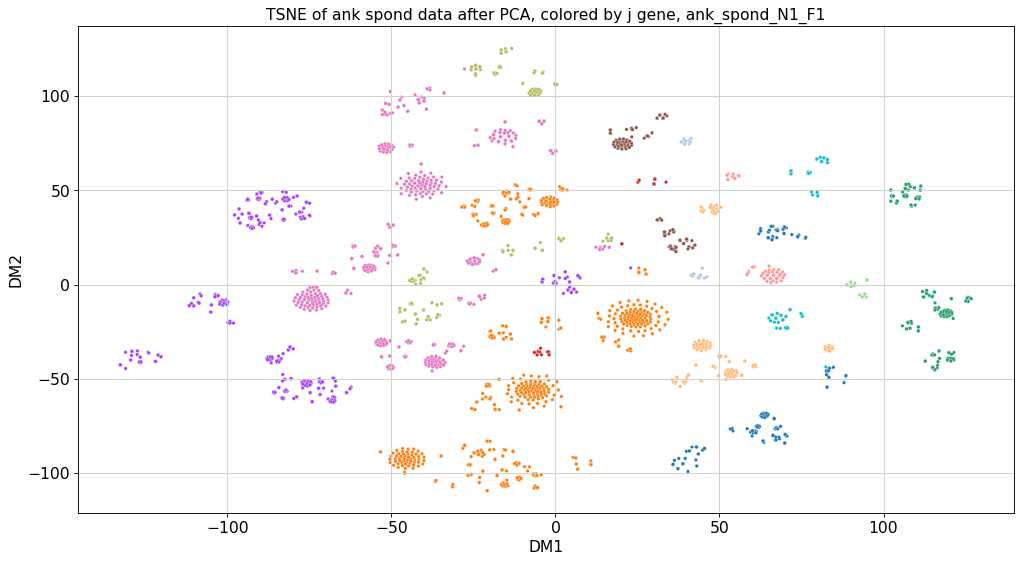

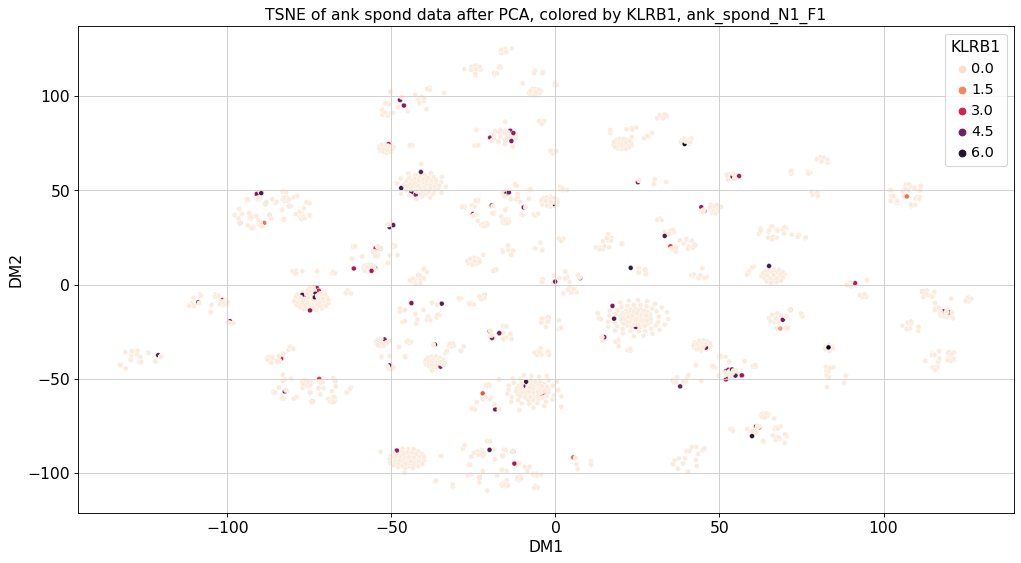

In [46]:
plt.figure(figsize=(15,8))
ax = sns.scatterplot('DM1', 'DM2', data=tsne_df_data, hue='j_gene',s=10,legend = False)
ax.set_title("TSNE of ank spond data after PCA, colored by j gene, " + prefix[donor])
plt.figure(figsize=(15,8))
ax = sns.scatterplot('DM1', 'DM2', data=tsne_df_data, hue='KLRB1',s=20,palette = 'rocket_r')
ax.set_title("TSNE of ank spond data after PCA, colored by KLRB1, " + prefix[donor])

/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'TSNE of ank spond data after PCA, colored by KLRB1, ank_spond_N1_F1')

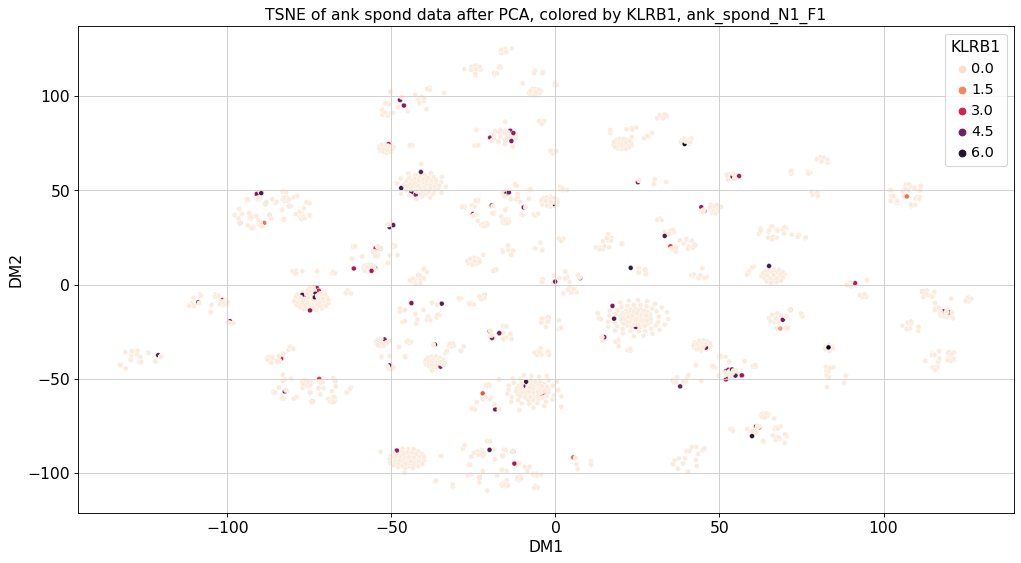

In [47]:
plt.figure(figsize=(15,8))
ax = sns.scatterplot('DM1', 'DM2', data=tsne_df_data[tsne_df_data['DM2']<200], hue='KLRB1',s=20,palette = 'rocket_r')
ax.set_title("TSNE of ank spond data after PCA, colored by KLRB1, " + prefix[donor])

## Clustering

In [48]:
kmeans = KMeans(n_clusters=20, random_state=0).fit(pca_df)

In [49]:
clusters = pd.DataFrame(kmeans.labels_, columns= ['cluster'])
df_kmeans = pd.concat([tsne_df_data, clusters], axis = 1)
df_kmeans

DM1         DM2           barcode   j_gene    v_gene     KLRB1  \
0      43.060963  -96.208519  CACAGTAGTATATCCG  TRBJ1-1   TRBV5-1 -0.205393   
1     -46.038109 -100.084473  TCAGGATCAAGGTTTC  TRBJ2-1   TRBV7-8 -0.205393   
2     110.594223  -24.563480  TTCTCCTAGTGACTCT  TRBJ1-2   TRBV5-1 -0.205393   
3      10.777803  -93.623436  TGACGGCTCGTTACAG  TRBJ2-1  TRBV12-5 -0.205393   
4      -5.587585  -37.239628  ATCCACCTCTGCGACG  TRBJ2-4   TRBV7-8 -0.205393   
...          ...         ...               ...      ...       ...       ...   
2777   -9.102558   41.075836  GGATTACCAAGCGTAG  TRBJ2-1   TRBV6-3 -0.205393   
2778   13.459515   18.644468  GCAGTTAGTCTACCTC  TRBJ2-3  TRBV20-1 -0.205393   
2779   25.514006   55.346947  ATGTGTGTCGCGTAGC  TRBJ2-4    TRBV27 -0.205393   
2780  -28.515627   41.120495  CGATTGATCATCTGTT  TRBJ2-1  TRBV10-3 -0.205393   
2781  114.757027   -6.423650  GCCAAATTCCAAGCCG  TRBJ1-2   TRBV4-1 -0.205393   

      KLRB1_bool  cluster  
0              0        8  
1              0        9  
2              0        4  
3              0        9  
4              0        7  
...          ...      ...  
2777           0       11  
2778           0        0  
2779           0        3  
2780           0       11  
2781           0        4  

[2782 rows x 8 columns]

/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'TSNE of ank spond data after PCA, colored by cluster, ank_spond_N1_F1')

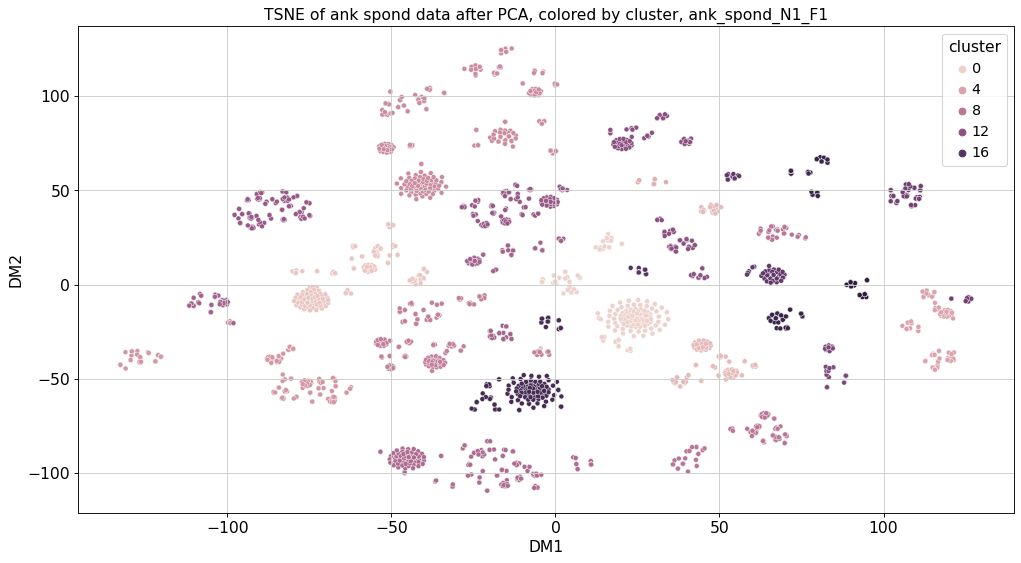

In [50]:
plt.figure(figsize=(15,8))
ax = sns.scatterplot('DM1', 'DM2', data=df_kmeans, hue='cluster',s=20)
ax.set_title("TSNE of ank spond data after PCA, colored by cluster, " + prefix[donor])

In [51]:
barcodes_cluster = pd.merge(barcodes, df_kmeans[['barcode','cluster']], how='left', on=['barcode'])
barcodes_cluster['cluster'] = barcodes_cluster['cluster']
barcodes_cluster = barcodes_cluster.fillna('no_cluster')
barcodes_cluster = barcodes_cluster.set_index('barcode')

In [48]:
binom_df_cluster = data_processing.binominal_test(df_kmeans,'cluster','KLRB1_bool')
binom_df_cluster.head(40)

KLRB1_bool  cluster  total_cluster  total_group  count_mached  \
65             0        3             80         3707            75   
30             0        4            216         3707           201   
37             0        9            135         3707           120   
13             0       16            293         3707           259   
7              0        2            245         3707           209   
8              0        6            181         3707           154   
1              0        7            215         3707           182   
21             0       15            243         3707           205   
25             0       14            281         3707           231   
0              0       12            144         3707           118   
80             0        0             73         3707            59   
53             0       20            121         3707            97   
56             0       22             75         3707            59   
93             0       17            120         3707            93   
147            0       11            159         3707           122   
1333           1       18            108         1146            47   
14             1        5            182         1146            77   
19             1        8            401         1146           162   
156            1       24             84         1146            32   
272            1       13            213         1146            76   
68             1        1            435         1146           129   
275            1       21            249         1146            71   
87             1       23             67         1146            18   
6              1       10            342         1146            91   
194            1       19            191         1146            46   

      fraction_mached  fraction_mached_exp       p_value  
65           0.937500             0.763857  3.722357e-05  
30           0.930556             0.763857  7.652106e-11  
37           0.888889             0.763857  1.808272e-04  
13           0.883959             0.763857  1.438875e-07  
7            0.853061             0.763857  3.812316e-04  
8            0.850829             0.763857  2.682335e-03  
1            0.846512             0.763857  1.931523e-03  
21           0.843621             0.763857  1.501814e-03  
25           0.822064             0.763857  1.119919e-02  
0            0.819444             0.763857  6.733672e-02  
80           0.808219             0.763857  2.285037e-01  
53           0.801653             0.763857  1.928587e-01  
56           0.786667             0.763857  3.793667e-01  
93           0.775000             0.763857  4.359088e-01  
147          0.767296             0.763857  5.031033e-01  
1333         0.435185             0.236143  4.145463e-06  
14           0.423077             0.236143  2.016973e-08  
19           0.403990             0.236143  6.983733e-14  
156          0.380952             0.236143  2.119870e-03  
272          0.356808             0.236143  4.982141e-05  
68           0.296552             0.236143  2.222271e-03  
275          0.285141             0.236143  4.254591e-02  
87           0.268657             0.236143  3.078909e-01  
6            0.266082             0.236143  1.084994e-01  
194          0.240838             0.236143  4.671179e-01

In [ ]:
adata_copy = adata.copy()
adata_copy.obs['cluster'] = barcodes_cluster['cluster'].astype(str)

In [ ]:
sc.pl.tsne(adata_copy, color="cluster",title = 'tsne of 10x expression data colored by tcr-embedding clusters, ' + prefix[donor] )

In [114]:
distortions = []
K = range(20,100)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(pca_df)
    distortions.append(kmeanModel.inertia_)

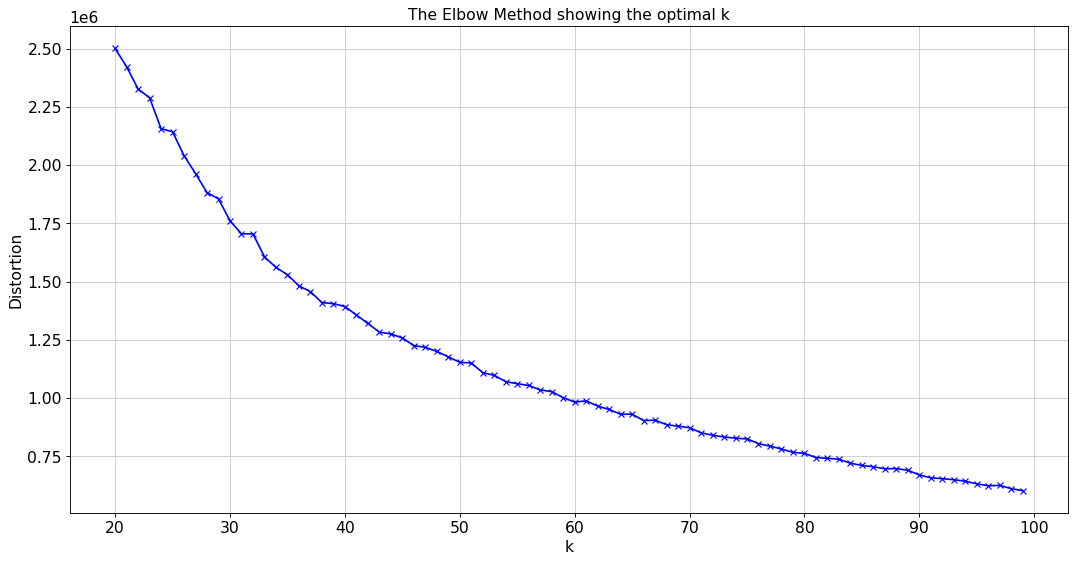

In [115]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()